In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import seaborn as sns
import os
import configs
from math import ceil, floor

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
from utils_summary_statistics import *
import configs
from script_fig4_run_resolution_sweep import param_sweep_search_strengths

# Choose experiment to load

In [2]:
# Specify what you're looking at
exp = 'weight_var'
model_type = 'default'
exp_df_key = 'weight var'
exp_label = 'Weight Var'

In [3]:
if os.environ['USER'] == 'chingfang':
    engram_dir = '/Volumes/aronov-locker/Ching/barcodes2/' # Local Path
elif 'SLURM_JOBID' in os.environ.keys():
    engram_dir = '/mnt/smb/locker/aronov-locker/Ching/barcodes2/' # Axon Path
else:
    engram_dir = '/home/cf2794/engram/Ching/barcodes2/' # Cortex Path
exp_dir = os.path.join(engram_dir, 'resolution', exp, model_type)

In [4]:
N_inp = 5000
N_bar = 5000
num_states = 100
inputs = PlaceInputs(N_inp, num_states).get_inputs()

In [5]:
load = True

In [6]:
if load:
    with open(f'pickles/resolution_{exp}.p', 'rb') as f:
        summary_stats = pickle.load(f)
else:
    summary_stats = {}

    for param in os.listdir(exp_dir):
        if param == '.DS_Store': continue
        dirpath = os.path.join(exp_dir, param)
        for site_spacing in os.listdir(dirpath):
            if not site_spacing.startswith('res'): continue    
            dirpath = os.path.join(exp_dir, param, site_spacing)
            for seed in os.listdir(dirpath):
                if not seed.startswith('seed'): continue
                dirpath = os.path.join(exp_dir, param, site_spacing, seed)
                _param = round(float(param), 2)
                _seed = int(seed[4:])
                _site_spacing = int(site_spacing[3:])
                cache_states = [0, _site_spacing, 66]

                try:
                    with open(os.path.join(dirpath, 'results.p'), 'rb') as f:
                        _results = pickle.load(f)
                except:
                    continue

                for s in param_sweep_search_strengths:
                    readout = _results[f'{s:.2f}_seed_reconstruct'].flatten()
                    readout /= readout.max()
                    reconstruct = _results[f'{s:.2f}_reconstruct'].copy()
                    activations = _results[f'{s:.2f}_acts'].copy()
                    _summary_stats = get_resolution_summary_statistics(
                        readout, reconstruct, cache_states, activations,
                        inputs, _site_spacing, search_strength=s)
                    for key, _dict in _summary_stats.items():
                        n_samples = len(_dict[list(_dict.keys())[0]])
                        _dict[exp_df_key] = [_param]*n_samples
                        if key not in summary_stats.keys():
                            summary_stats[key] = _dict
                        else:
                            for nested_key in _dict.keys():
                                summary_stats[key][nested_key].extend(_dict[nested_key])
    with open(f'pickles/resolution_{exp}.p', 'wb') as f:
        pickle.dump(summary_stats, f)

# Identifying the Presence of a Cache

### Sensitivity/Specificity at different thresholds

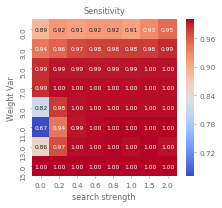

In [7]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df['threshold']==0.5]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'sensitivity')
fig, ax = plt.subplots(figsize=(3.2,3))
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm',
    fmt=".2f", annot_kws={"size": 6})
plt.title('Sensitivity')
plt.ylabel(exp_label)
plt.tight_layout()
plt.savefig('figures/figS4b_a.svg', dpi=300, transparent=True)
plt.show()

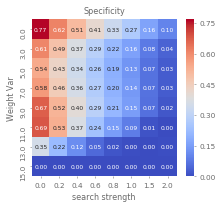

In [8]:
df = pd.DataFrame(summary_stats['identification_1'])
df = df[df['threshold']==0.5]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'specificity')
fig, ax = plt.subplots(figsize=(3.2,3))
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm',
    fmt=".2f", annot_kws={"size": 6})
plt.title('Specificity')
plt.ylabel(exp_label)
plt.tight_layout()
plt.savefig('figures/figS4b_b.svg', dpi=300, transparent=True)
plt.show()

### How correct are sites between cache 1 and cache 2?

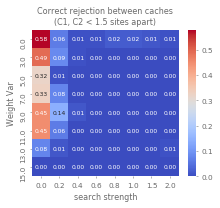

In [9]:
df = pd.DataFrame(summary_stats['identification_2'])
df['binarized'] = df['noncache val'] < 0.5
df = df[df['site spacing'] <= 15]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'binarized')
fig, ax = plt.subplots(figsize=(3.2,3))
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm',
    fmt=".2f", annot_kws={"size": 6})
plt.title('Correct rejection between caches\n(C1, C2 < 1.5 sites apart)')
plt.ylabel(exp_label)
plt.tight_layout()
plt.savefig('figures/figS4b_c.svg', dpi=300, transparent=True)
plt.show()

# Reconstruction

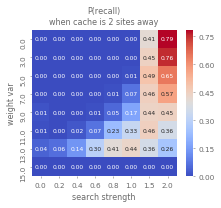

In [10]:
df = pd.DataFrame(summary_stats['reconstruct_1'])
df = df[df['site spacing']>15]
df['val'] = df['is_closest'] & df['high_readout']
df = df[df['distance from closest cache']==20]
df = df.groupby([exp_df_key, 'search strength']).mean().reset_index()
heatmap_data = df.pivot(exp_df_key, 'search strength', 'val')
fig, ax = plt.subplots(figsize=(3.2,3))
sns.heatmap(
    heatmap_data, annot=True, cmap='coolwarm',
    fmt=".2f", annot_kws={"size": 6})
plt.title('P(recall)\nwhen cache is 2 sites away')
plt.tight_layout()
plt.savefig('figures/figS4b_d.svg', dpi=300, transparent=True)
plt.show()